In [75]:
from collections import defaultdict

import numpy as np
import matplotlib.pylab as plt
import pandas as pd

# scikit-hep
import awkward as ak
import uproot
import vector
vector.register_awkward()
import correctionlib

### Load data from NTuples without materialising in memory

!! Install `xrootd` via `conda-forge`

In [77]:
####### Backgrounds
# W+jets
# dataset = "Wjets"
# filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/00702195-E707-3743-8BBA-57EB9DEE1DBA.root'

# ttbar leptonic
# dataset = "tt_lep"
# filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIIFall15MiniAODv2/TTTo2L2Nu_13TeV-powheg/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12-v1/00000/02A468DA-E8B9-E511-942C-0022195E688C.root'

datasets = {
    "signal": "root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/ZprimeToTT_M2000_W20_TuneCP2_PSweights_13TeV-madgraph-pythiaMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/22BAB5D2-9E3F-E440-AB30-AE6DBFDF6C83.root",
    "tt_semilep": "root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/08FCB2ED-176B-064B-85AB-37B898773B98.root",
    "tt_had": "root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/130000/009086DB-1E42-7545-9A35-1433EC89D04B.root",
}

events = defaultdict(dict)
for dataset, filename in datasets.items():
    print(f"Opening {dataset} file: {filename}")
    # Open the file
    with uproot.open(filename) as f:
        f = uproot.open(filename)
        events[dataset]= {"events": f['Events']}
        nevents = events[dataset]["events"].num_entries
        events[dataset].update({"nevents": nevents})
        print(f"{dataset}: {nevents = }")

Opening signal file: root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/ZprimeToTT_M2000_W20_TuneCP2_PSweights_13TeV-madgraph-pythiaMLM-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/22BAB5D2-9E3F-E440-AB30-AE6DBFDF6C83.root
signal: nevents = 11503
Opening tt_semilep file: root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/08FCB2ED-176B-064B-85AB-37B898773B98.root
tt_semilep: nevents = 1233000
Opening tt_had file: root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/130000/009086DB-1E42-7545-9A35-1433EC89D04B.root
tt_had: nevents = 1344000


### Read branches into memory 

In [ ]:
for dataset, data in events.items():
    dataset_events = data["events"]
    print(f"Processing {dataset} dataset")
    # Load the branches we need
    events[dataset]["muon_pt"] = dataset_events["Muon_pt"].array()
    events[dataset]["muon_eta"] = dataset_events["Muon_eta"].array()
    events[dataset]["muon_phi"] = dataset_events["Muon_phi"].array()
    events[dataset]["muon_mass"] = dataset_events["Muon_mass"].array()
    events[dataset]["muon_iso"] = dataset_events["Muon_miniIsoId"].array()
    events[dataset]["muon_tightId"] = dataset_events["Muon_tightId"].array()

    events[dataset]["fatjet_tag"] = dataset_events["FatJet_particleNet_TvsQCD"].array()
    events[dataset]["fatjet_pt"] = dataset_events["FatJet_pt"].array()
    events[dataset]["fatjet_eta"] = dataset_events["FatJet_eta"].array()
    events[dataset]["fatjet_phi"] = dataset_events["FatJet_phi"].array()
    events[dataset]["fatjet_mass"] = dataset_events["FatJet_mass"].array()

    events[dataset]["jet_btag"] = dataset_events["Jet_btagDeepB"].array()
    events[dataset]["jet_jetid"] = dataset_events["Jet_jetId"].array()
    events[dataset]["jet_pt"] = dataset_events["Jet_pt"].array()
    events[dataset]["jet_eta"] = dataset_events["Jet_eta"].array()
    events[dataset]["jet_phi"] = dataset_events["Jet_phi"].array()
    events[dataset]["jet_mass"] = dataset_events["Jet_mass"].array()

    events[dataset]["met_pt"] = dataset_events["PuppiMET_pt"].array()
    events[dataset]["met_eta"] = 0 * dataset_events["PuppiMET_pt"].array()  # Fix this to be 0 !!
    events[dataset]["met_phi"] = dataset_events["PuppiMET_phi"].array()
    #==================== Event variables =========================
    events[dataset]["ht_lep"] = events[dataset]["muon_pt"] + events[dataset]["met_pt"]

    # meta
    events[dataset]["weights"] = dataset_events["genWeight"].array()
    events[dataset]["nTrueInt"] = dataset_events["Pileup_nTrueInt"].array()


Processing signal dataset
Processing tt_semilep dataset
Processing tt_had dataset


### Define object and event selection

In [ ]:
#tau32 = fatjet_tau3/fatjet_tau2
#cut_fatjet = (tau32>0.67) & (fatjet_eta>-2.4) & (fatjet_eta<2.4) & (fatjet_mSD>105) & (fatjet_mSD<220)
for dataset, data in events.items():

    events[dataset]["obj_sel"] = {
        "fatjets": (data["fatjet_pt"] > 500) & (data["fatjet_tag"] > 0.5),
        "muons": (data["muon_pt"] > 55) & (data["muon_eta"] > -2.4) & (data["muon_eta"] < 2.4) &
                (data["muon_tightId"] == True) & (data["muon_iso"] > 1) & (data["ht_lep"] > 150),
        "jets": (data["jet_btag"] > 0.5) & (data["jet_jetid"] >= 4)
    }
    # Event cut
    events[dataset]["event_sel"] = {
        "met": (data["met_pt"] > 50),
        "nmuons": (ak.sum(data["obj_sel"]["muons"], axis=1) == 1),
        "trigger": (data["events"]["HLT_TkMu50"].array()),
        "btag": (ak.sum(data["obj_sel"]["jets"], axis=1) > 0),
        "ntop": (ak.sum(data["obj_sel"]["fatjets"], axis=1) == 1)
    }
    events[dataset]["event_sel"]["full"] = (
        (events[dataset]["event_sel"]["trigger"]) &
        (events[dataset]["event_sel"]["nmuons"]) &
        (events[dataset]["event_sel"]["met"]) &
        (events[dataset]["event_sel"]["ntop"]) &
        (events[dataset]["event_sel"]["btag"])
    )

    full_event_sel = events[dataset]["event_sel"]["full"]

    print(f"Fraction of {dataset} events left: ", ak.sum(events[dataset]["event_sel"]["full"])/nevents)

    fatjets = ak.zip(
        {
            "pt": data["fatjet_pt"][full_event_sel][data["obj_sel"]["fatjets"][full_event_sel]],
            "eta": data["fatjet_eta"][full_event_sel][data["obj_sel"]["fatjets"][full_event_sel]],
            "phi": data["fatjet_phi"][full_event_sel][data["obj_sel"]["fatjets"][full_event_sel]],
            "mass": data["fatjet_mass"][full_event_sel][data["obj_sel"]["fatjets"][full_event_sel]],
        },
        with_name="Momentum4D",
    )
    events[dataset]["fatjets"] = fatjets

    muons = ak.zip(
        {
            "pt": data["muon_pt"][full_event_sel][data["obj_sel"]["muons"][full_event_sel]],
            "eta": data["muon_eta"][full_event_sel][data["obj_sel"]["muons"][full_event_sel]],
            "phi": data["muon_phi"][full_event_sel][data["obj_sel"]["muons"][full_event_sel]],
            "mass": data["muon_mass"][full_event_sel][data["obj_sel"]["muons"][full_event_sel]],
        },
        with_name="Momentum4D",
    )
    events[dataset]["muons"] = muons

    jets = ak.zip(
        {
            "pt": data["jet_pt"][full_event_sel][data["obj_sel"]["jets"][full_event_sel]][:, 0],
            "eta": data["jet_eta"][full_event_sel][data["obj_sel"]["jets"][full_event_sel]][:, 0],
            "phi": data["jet_phi"][full_event_sel][data["obj_sel"]["jets"][full_event_sel]][:, 0],
            "mass": data["jet_mass"][full_event_sel][data["obj_sel"]["jets"][full_event_sel]][:, 0],
        },
        with_name="Momentum4D",
    )
    events[dataset]["jets"] = jets

    met = ak.zip(
        {
            "pt": data["met_pt"][data["event_sel"]["full"]],
            "eta": data["met_eta"][data["event_sel"]["full"]],
            "phi": data["met_phi"][data["event_sel"]["full"]],
            "mass": 0,
        },
        with_name="Momentum4D",
    )
    events[dataset]["met"] = met

    p4mu,p4fj,p4j,p4met = ak.unzip(ak.cartesian([muons, fatjets, jets, met]))
    p4tot = p4mu + p4fj + p4j + p4met
    events[dataset]["p4tot"] = p4tot
    events[dataset]['mtt'] = ak.flatten(p4tot.mass)
    events[dataset]['mu_pt'] = ak.flatten(p4mu.pt)
    events[dataset]['mu_abseta'] = np.abs(ak.flatten(p4mu.eta))
    events[dataset]['weight'] = data[dataset]["weights"][full_event_sel]
    events[dataset]['pileup'] = data[dataset]["nTrueInt"][full_event_sel]


Fraction of signal events left:  0.00045684523809523807
Fraction of tt_semilep events left:  0.00044419642857142856
Fraction of tt_had events left:  3.7202380952380952e-06


Plotting signal dataset


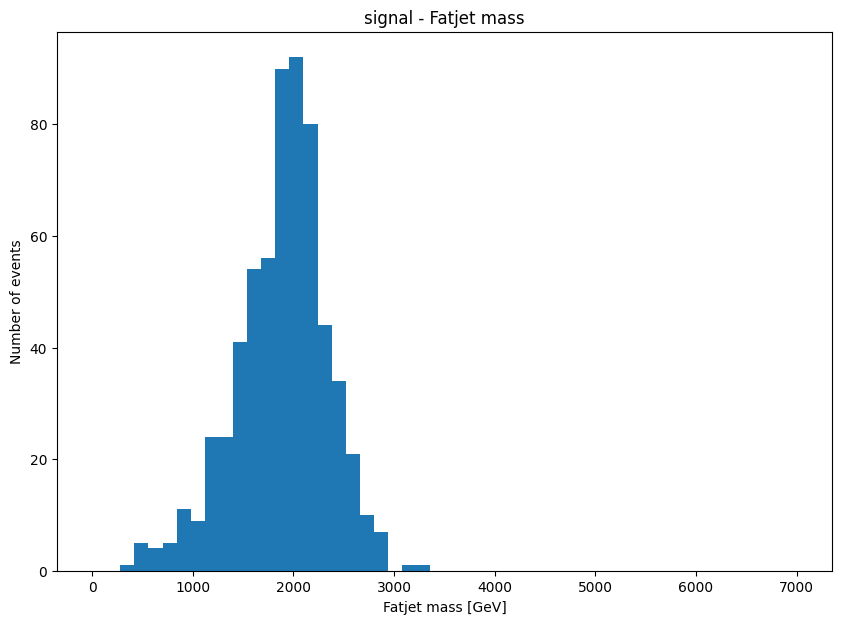

Plotting tt_semilep dataset


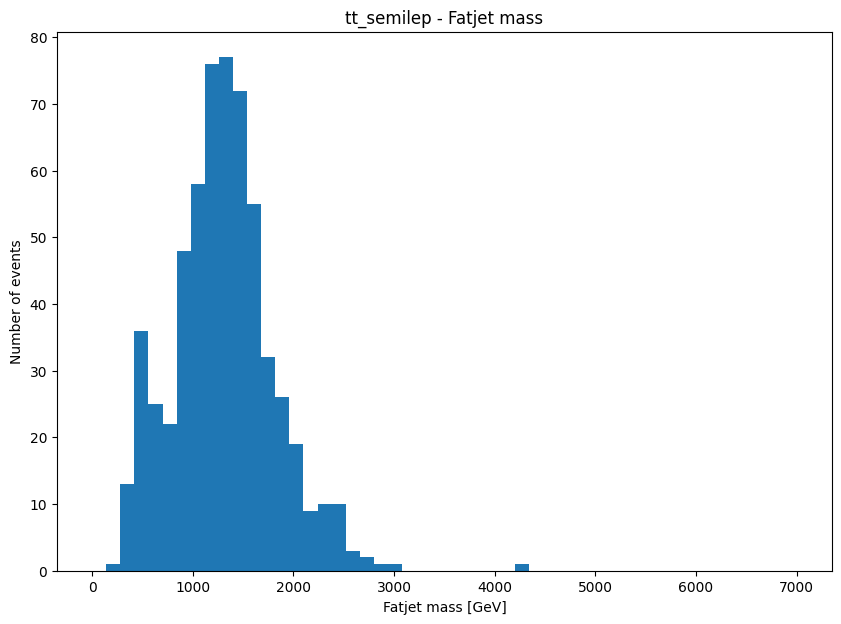

Plotting tt_had dataset


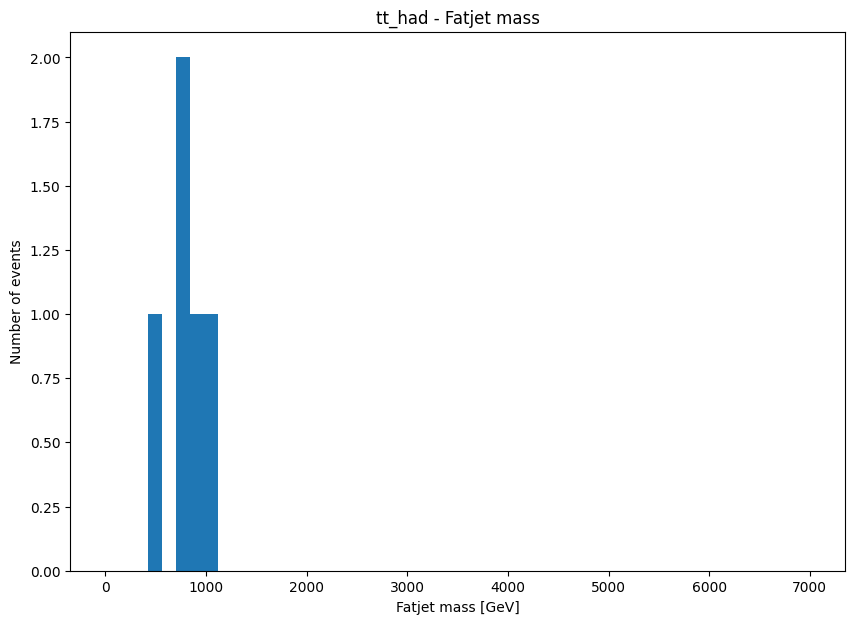

In [ ]:
for dataset, data in events.items():
    print(f"Plotting {dataset} dataset")
    fatjets = data["fatjets"]
    muons = data["muons"]
    jets = data["jets"]
    met = data["met"]

    # Plotting
    plt.figure(figsize=(10, 7))
    plt.title(f"{dataset} - Fatjet mass")
    plt.hist(ak.flatten(p4tot.mass),bins=50, range=(0,7000));
    plt.xlabel("Fatjet mass [GeV]")
    plt.ylabel("Number of events")
    plt.show()

In [ ]:

for dataset, data in events.items():
    to_write = {}
    to_write['mtt'] = data['mtt']
    to_write['mu_pt'] = data['mu_pt']
    to_write['mu_abseta'] = data['mu_abseta']

    to_write['weight'] = data["weights"]
    to_write['pileup'] = data["pileup"]
    df = pd.DataFrame.from_dict(to_write)
    outfilename = f"output_{dataset}_{filename.split('/')[-1].split('.')[0]}.csv"
    df.to_csv(outfilename, index=False)

In [49]:
import gzip
with gzip.open("puWeights.json.gz",'rt') as file:
    data = file.read().strip()
    pu_corr_evaluator = correctionlib._core.CorrectionSet.from_string(data)

with gzip.open("./muon_Z.json.gz",'rt') as file:
    data = file.read().strip()
    muo_corr_evaluator = correctionlib._core.CorrectionSet.from_string(data)

In [ ]:
import gzip
datadict = {}
datadict['signal'] = np.genfromtxt('output_signal_22BAB5D2-9E3F-E440-AB30-AE6DBFDF6C83.csv', delimiter=',', names=True, dtype=float)
datadict['tt_semilep'] = np.genfromtxt('output_tt_semilep_08FCB2ED-176B-064B-85AB-37B898773B98.csv', delimiter=',', names=True, dtype=float)
datadict['tt_had'] = np.genfromtxt('output_tt_had_009086DB-1E42-7545-9A35-1433EC89D04B.csv', delimiter=',', names=True, dtype=float)

hists = {}
for sample in datadict.keys():
    print(sample)
    hists[sample] = {
        "pu": datadict[sample]['pileup'],
        "mu_pt": datadict[sample]['mu_pt'],
        "mu_abseta": datadict[sample]['mu_abseta'],
        "genWeight": datadict[sample]['weight']/np.abs(datadict[sample]['weight']),
        "mtt": datadict[sample]['mtt'],
        "pu_weight": [pu_corr_evaluator["Collisions16_UltraLegacy_goldenJSON"].evaluate(n,"nominal") for n in datadict[sample]['pileup']],
        "pu_weight_up": [pu_corr_evaluator["Collisions16_UltraLegacy_goldenJSON"].evaluate(n,"up") for n in datadict[sample]['pileup']],
        "pu_weight_dn": [pu_corr_evaluator["Collisions16_UltraLegacy_goldenJSON"].evaluate(n,"down") for n in datadict[sample]['pileup']],
        "leadmuon_sf": [muo_corr_evaluator["NUM_TightID_DEN_TrackerMuons"].evaluate(eta,pt,"nominal") for pt,eta in zip(datadict[sample]['mu_pt'],datadict[sample]['mu_abseta'])],
        "leadmuon_sf_up": [muo_corr_evaluator["NUM_TightID_DEN_TrackerMuons"].evaluate(eta,pt,"systup") for pt,eta in zip(datadict[sample]['mu_pt'],datadict[sample]['mu_abseta'])],
        "leadmuon_sf_dn": [muo_corr_evaluator["NUM_TightID_DEN_TrackerMuons"].evaluate(eta,pt,"systdown") for pt,eta in zip(datadict[sample]['mu_pt'],datadict[sample]['mu_abseta'])],
    }

signal
tt_semilep
tt_had


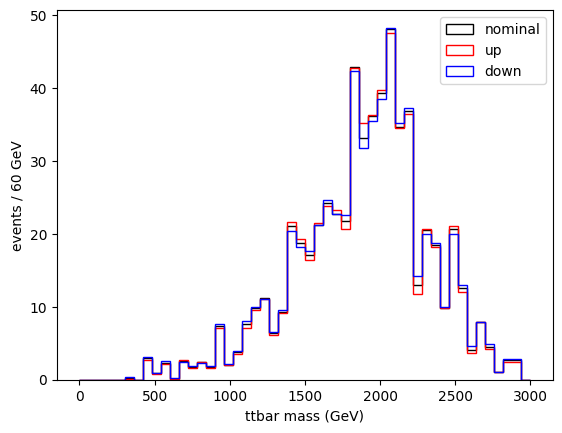

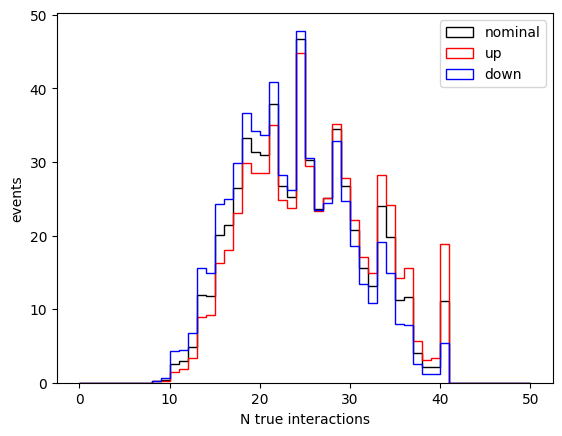

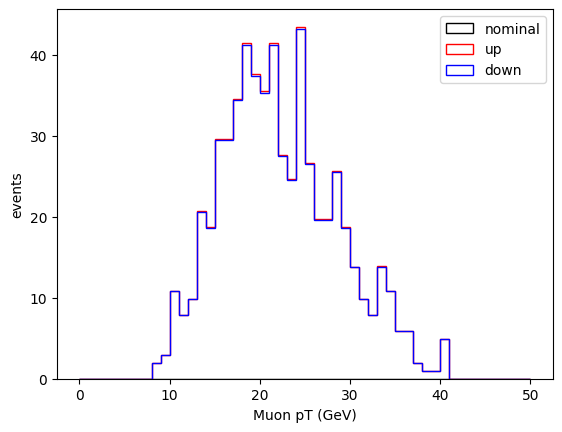

In [56]:
plt.hist(hists['signal']['mtt'],
         bins=50,range=(0,3000),
         weights=hists['signal']['genWeight']*hists['signal']['pu_weight'],
         histtype="step",color="k",label="nominal")
plt.hist(hists['signal']['mtt'],
         bins=50,range=(0,3000),
         weights=hists['signal']['genWeight']*hists['signal']['pu_weight_up'],
         histtype="step",color="r",label="up")
plt.hist(hists['signal']['mtt'],
         bins=50,range=(0,3000),
         weights=hists['signal']['genWeight']*hists['signal']['pu_weight_dn'],
         histtype="step",color="b",label="down")
plt.legend()
plt.xlabel('ttbar mass (GeV)')
plt.ylabel('events / 60 GeV')
plt.show()

plt.hist(hists['signal']['pu'],
         bins=50,range=(0,50),
         weights=hists['signal']['genWeight']*hists['signal']['pu_weight'],
         histtype="step",color="k",label="nominal")
plt.hist(hists['signal']['pu'],
         bins=50,range=(0,50),
         weights=hists['signal']['genWeight']*hists['signal']['pu_weight_up'],
         histtype="step",color="r",label="up")
plt.hist(hists['signal']['pu'],
         bins=50,range=(0,50),
         weights=hists['signal']['genWeight']*hists['signal']['pu_weight_dn'],
         histtype="step",color="b",label="down")
plt.legend()
plt.xlabel('N true interactions')
plt.ylabel('events')
plt.show()

plt.hist(hists['signal']['mu_pt'],
         bins=50,range=(0,50),
         weights=hists['signal']['genWeight']*hists['signal']['leadmuon_sf'],
         histtype="step",color="k",label="nominal")
plt.hist(hists['signal']['pu'],
         bins=50,range=(0,50),
         weights=hists['signal']['genWeight']*hists['signal']['leadmuon_sf_up'],
         histtype="step",color="r",label="up")
plt.hist(hists['signal']['pu'],
         bins=50,range=(0,50),
         weights=hists['signal']['genWeight']*hists['signal']['leadmuon_sf_dn'],
         histtype="step",color="b",label="down")
plt.legend()
plt.xlabel('Muon pT (GeV)')
plt.ylabel('events')
plt.show()

In [57]:
import pickle
with open('hists_for_ROOT.p','wb') as f:
    pickle.dump(hists,f)